### XGBoost and Lightgbm Remind

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sys
print(sys.executable, sys.path)

from xgboost import XGBClassifier, plot_importance as xgb_plot
from lightgbm import LGBMClassifier, plot_importance as lgb_plot

/usr/bin/python3 ['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

In [3]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred, average='macro')
    
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

In [4]:
# colab path
df = pd.read_csv('/content/drive/MyDrive/algorithm/datasets/application_data.csv')
print(df.shape, df.info())

df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
(307511, 122) None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


0    282686
1     24825
Name: TARGET, dtype: int64


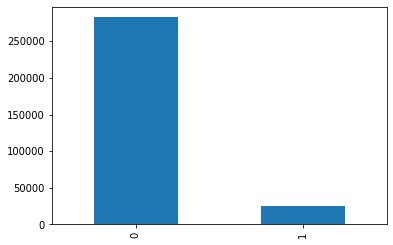

In [5]:
print(df['TARGET'].value_counts())
df['TARGET'].value_counts().plot(kind='bar')

In [6]:
df = df.dropna(axis=1)
print(df.shape)
df.head(10)

(307511, 55)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,...,0,0,0,0,0,0,0,0,0,0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,...,0,0,0,0,0,0,0,0,0,0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,...,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,...,0,0,0,0,0,0,0,0,0,0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,...,0,0,0,0,0,0,0,0,0,0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,...,0,0,0,0,0,0,0,0,0,0


#### No SMOTE: feature encode

In [7]:
x = df.iloc[:,2:]
y = df['TARGET']

print(x.shape, y.shape)

(307511, 53) (307511,)


In [8]:
print(x['NAME_CONTRACT_TYPE'].value_counts())

x.head(10)

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,...,0,0,0,0,0,0,0,0,0,0
1,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,...,0,0,0,0,0,0,0,0,0,0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,...,0,0,0,0,0,0,0,0,0,0
3,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,...,0,0,0,0,0,0,0,0,0,0
4,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,...,0,0,0,0,0,0,0,0,0,0
5,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,Secondary / secondary special,Married,...,0,0,0,0,0,0,0,0,0,0
6,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,Higher education,Married,...,0,0,1,0,0,0,0,0,0,0
7,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,Higher education,Married,...,0,0,0,0,0,0,0,0,0,0
8,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,Secondary / secondary special,Married,...,0,0,0,0,0,0,0,0,0,0
9,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,Secondary / secondary special,Single / not married,...,0,0,0,0,0,0,0,0,0,0


In [9]:
encode = OrdinalEncoder()

df_encode = encode.fit_transform(x)

x = pd.DataFrame(df_encode, columns=x.columns)
x.head(10)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0.0,1.0,0.0,1.0,0.0,1754.0,1191.0,7.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2064.0,4338.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,338.0,228.0,7.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1170.0,836.0,7.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1019.0,1635.0,7.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,1.0,0.0,719.0,1533.0,4.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,1519.0,4882.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,1.0,1.0,0.0,2256.0,4836.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,904.0,3471.0,3.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,1.0,0.0,1170.0,1185.0,7.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=9095)

In [11]:
def modeling(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    metrics(y_test, pred)

In [12]:
## compared lr(logistic regression)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
modeling(lr, x_train, x_test, y_train, y_test)

# => Label Imbalance 문제

정확도 : 0.92, 정밀도 : 0.00, 재현율 : 0.00
f1-score : 0.00, auc : 0.50


### GridSearchCV params

In [13]:
# xgb = XGBClassifier()

# xgb_param_grid = {
#     'n_estimators' : [600, 800],
#     'learning_rate' : [0.1, 0.15, 0.2],
#     'max_depth' : [4, 6, 8, 10, 12]
# }

In [14]:
# xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc', n_jobs=-1)
# xgb_grid.fit(x_train, y_train)

In [15]:
# print("Best Params: ", xgb_grid.cv_results_)
# grid_result = pd.DataFrame(xgb_grid.best_score_)

# grid_result[['params', 'mean_test_score', 'rank_test_score']].head(10)

In [19]:
xgb = XGBClassifier(n_estimators=600, learning_rate=0.2, max_depth=4)
evals = [(x_test, y_test)]

xgb.fit(x_train, y_train, early_stopping_rounds= 30, eval_metric= 'auc', eval_set= evals)

[0]	validation_0-auc:0.622335
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.633261
[2]	validation_0-auc:0.636639
[3]	validation_0-auc:0.643754
[4]	validation_0-auc:0.644843
[5]	validation_0-auc:0.646571
[6]	validation_0-auc:0.648503
[7]	validation_0-auc:0.64891
[8]	validation_0-auc:0.649616
[9]	validation_0-auc:0.651597
[10]	validation_0-auc:0.653543
[11]	validation_0-auc:0.657142
[12]	validation_0-auc:0.658556
[13]	validation_0-auc:0.660298
[14]	validation_0-auc:0.662192
[15]	validation_0-auc:0.663997
[16]	validation_0-auc:0.66522
[17]	validation_0-auc:0.666726
[18]	validation_0-auc:0.667763
[19]	validation_0-auc:0.669014
[20]	validation_0-auc:0.669589
[21]	validation_0-auc:0.670445
[22]	validation_0-auc:0.671596
[23]	validation_0-auc:0.672745
[24]	validation_0-auc:0.673021
[25]	validation_0-auc:0.673639
[26]	validation_0-auc:0.674528
[27]	validation_0-auc:0.675094
[28]	validation_0-auc:0.675259
[29]	validation_0-auc:0.675818
[30]	validation_0-

XGBClassifier(learning_rate=0.2, max_depth=4, n_estimators=600)